In [1]:
from modules.pipeline import Pipeline

In [2]:
pipe = Pipeline()

C:\Users\fpsaw\Desktop\42578-Advanced-Business-Analytics\modules\loader.py:113: FutureWarning: The default value of regex will change from True to False in a future version.
  df['username'] = df['username'].str.replace(


- sales quantity - poisson distribution
- price volume - gamma distribution

In [3]:
import datetime
# today = datetime.datetime.now()
today = datetime.datetime.strptime("23.03.2022", "%d.%m.%Y")

In [56]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [5]:
df = pipe.df_sals
df = df.loc[df.ddate > (today - datetime.timedelta(days=365 * 2))]

In [6]:
df['quant_pos'] = df.quantity.apply(lambda x: x if x > 0 else 0)
df['quant_neg'] = df.quantity.apply(lambda x: x if x < 0 else 0)
df['high_value'] = (df.price / df.quantity) >= 400

<ipython-input-6-0ccd2085d039>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quant_pos'] = df.quantity.apply(lambda x: x if x > 0 else 0)
<ipython-input-6-0ccd2085d039>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quant_neg'] = df.quantity.apply(lambda x: x if x < 0 else 0)
<ipython-input-6-0ccd2085d039>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [7]:
# by all operations
df_total = df[['cust_id', 'sku', 'quant_pos', 'quant_neg', 'high_value', 'quantity']].groupby(['cust_id', 'sku']).sum()
df_total['return_ratio'] = np.abs(df_total.quant_neg) / np.abs(df_total.quant_pos)
df_total['high_value'] = df_total['high_value'].apply(lambda x: True if x > 0 else False)
df_total = df_total.drop(columns=['quant_neg'])
# by transactions (invoices)
df_ops = df[['cust_id', 'sku', 'invoice_no']].groupby(['cust_id', 'sku']).count()

In [8]:
# by basket (operations = days)
df_basket = df[['cust_id', 'sku', 'ddate', 'quantity', 'price']] \
            .groupby(['cust_id', 'sku', 'ddate']).sum().reset_index()
# by product in a basket
sku_percentiles = df_basket.groupby('sku') \
                           .agg({'quantity': [('quantile', lambda x: np.quantile(x, 0.9))]}) \
                           .droplevel(0, axis=1).reset_index()

In [9]:
# by date
df_dates = df_basket.loc[df_basket.quantity > 0] \
                    .sort_values(by='ddate').groupby(['cust_id', 'sku']).agg({
    'ddate' : [('recent', lambda x: today - x.max()), 
               ('median_interval', lambda x: x.diff().median().total_seconds() / (60*60*24))]
}).droplevel(0, axis=1)
df_dates['recent'] = df_dates['recent'].dt.days

In [10]:
# combine
df_metrics = pd.merge(df_total, df_ops, on=['cust_id', 'sku'])
df_metrics = pd.merge(df_metrics, df_dates, on=['cust_id', 'sku'], how='left')
df_metrics = pd.merge(df_metrics.reset_index(), sku_percentiles, on='sku', how='left')

In [15]:
def ranking(row):
    is_low_quantity = row.quant_pos <= 3
    is_recent = row.recent <= 30
    is_frequent = row.median_interval <= (30 * 3)
    is_not_returned = row.return_ratio <= 0.33
    is_large_volume = row.quantity >= row['quantile']
    has_more_transactions = row.invoice_no > 1
    
    if(is_low_quantity):
        if(is_recent):
            if(has_more_transactions):
                return 75
            return 50
        if(is_not_returned):
            return 25
        return 5
    
    if(is_recent):
        if(is_frequent):
            if(is_large_volume):
                return 100
            return 85
        if(row.high_value):
            return 75
        return 60
    
    if(is_not_returned):
        if(is_frequent):
            if(is_large_volume):
                return 70
            if(row.high_value):
                return 60
            return 50
        if(row.high_value):
            return 50
        return 40
    return 10

In [16]:
df_metrics['rank'] = df_metrics.apply(ranking, axis=1)

<AxesSubplot:>

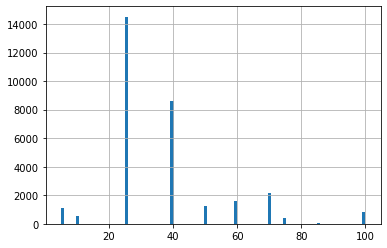

In [14]:
df_metrics['rank'].hist(bins=100)

<AxesSubplot:>

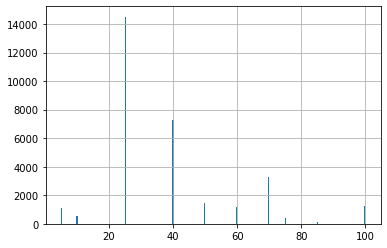

In [29]:
df_metrics['rank'].hist(bins=200)

In [18]:
df_metrics

,cust_id,sku,quant_pos,high_value,quantity,return_ratio,invoice_no,recent,median_interval,quantile,rank
0,00019,0-15-206,8,False,8,0.0,3,518.0,69.0,6.0,70
1,00019,0-20-556,16,False,16,0.0,6,34.0,77.0,6.0,70
2,00019,0-22-500,3,False,3,0.0,1,371.0,NaN,5.0,25
3,00019,0-28-500,18,False,18,0.0,5,34.0,162.5,10.0,40
4,00019,0-28-510,3,False,3,0.0,1,701.0,NaN,10.0,25
...,...,...,...,...,...,...,...,...,...,...,...
30993,998,KW712,17,False,17,0.0,9,42.0,48.5,4.0,70
30994,998,KX1650,19,False,19,0.0,7,128.0,53.5,10.0,70
30995,998,KX2200K,4,False,4,0.0,2,251.0,133.0,11.0,40
30996,998,L5.212.0091,3,False,3,0.0,1,461.0,NaN,10.0,25


In [114]:
from surprise import Dataset
from surprise import Reader


matrix = df_metrics[['sku', 'cust_id', 'rank']]

In [115]:
reader = Reader(rating_scale=(0, 100))
data = Dataset.load_from_df(matrix, reader)

In [116]:
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold, RepeatedKFold
from surprise import accuracy
from surprise import SVD

In [22]:
# train, test = train_test_split(data, test_size=0.2, random_state=123, shuffle=True)
# algo = SVD()

# algo.fit(trainset)
# predictions = algo.test(testset)

# # Compute and print Root Mean Squared Error
# accuracy.rmse(predictions, verbose=True)

In [31]:
from sklearn.metrics import r2_score

In [205]:
kf = KFold(n_splits=5)

algo = SVD(n_factors=300)

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    
#     testset = [
#         row for row in testset if row[2] not in [40, 25]
#     ]
    predictions = algo.test(testset)
    
    y_true = np.array([p.r_ui for p in predictions])
    y_pred = np.array([p.est for p in predictions])
    print(f'R2: \t {r2_score(y_true, y_pred)}')

    # Compute and print Root Mean Squared Error
    accuracy.mae(predictions, verbose=True)
    accuracy.rmse(predictions, verbose=True)
    print('-----------------')

R2: 	 0.2444546609792112
MAE:  13.9265
RMSE: 18.4291
-----------------
R2: 	 0.20817568882845816
MAE:  14.2362
RMSE: 18.8417
-----------------


KeyboardInterrupt: 

In [210]:
from surprise import NMF

kf = KFold(n_splits=5)
algo = NMF(n_factors=200, lr_bi=0.001)


for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)

#     testset = [
#         row for row in testset if row[2] not in [40, 25]
#     ]
    predictions = algo.test(testset)
    
    y_true = np.array([p.r_ui for p in predictions])
    y_pred = np.array([p.est for p in predictions])
    print(f'R2: \t {r2_score(y_true, y_pred)}')

    # Compute and print Root Mean Squared Error
    accuracy.mae(predictions, verbose=True)
    accuracy.rmse(predictions, verbose=True)
    print('-----------------')

R2: 	 0.052946284891869144
MAE:  16.0967
RMSE: 20.6100
-----------------
R2: 	 0.0437805877161872
MAE:  16.1303
RMSE: 20.7799
-----------------
R2: 	 -0.03001559869194992
MAE:  16.2614
RMSE: 21.0863
-----------------


KeyboardInterrupt: 

In [211]:
from surprise import SVDpp

kf = KFold(n_splits=5)
algo = SVDpp(n_factors=300)


for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)

#     testset = [
#         row for row in testset if row[2] not in [40, 25]
#     ]
    predictions = algo.test(testset)
    
    y_true = np.array([p.r_ui for p in predictions])
    y_pred = np.array([p.est for p in predictions])
    print(f'R2: \t {r2_score(y_true, y_pred)}')

    # Compute and print Root Mean Squared Error
    accuracy.mae(predictions, verbose=True)
    accuracy.rmse(predictions, verbose=True)
    print('-----------------')

KeyboardInterrupt: 

In [54]:
from surprise import KNNWithMeans

kf = KFold(n_splits=5)
algo = KNNWithMeans(k=20)


for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)

#     testset = [
#         row for row in testset if row[2] not in [40, 25]
#     ]
    predictions = algo.test(testset)
    
    y_true = np.array([p.r_ui for p in predictions])
    y_pred = np.array([p.est for p in predictions])
    print(f'R2: \t {r2_score(y_true, y_pred)}')

    # Compute and print Root Mean Squared Error
    accuracy.mae(predictions, verbose=True)
    accuracy.rmse(predictions, verbose=True)
    print('-----------------')

Computing the msd similarity matrix...
Done computing similarity matrix.
R2: 	 0.11608603579429622
MAE:  14.6449
RMSE: 19.8732
-----------------
Computing the msd similarity matrix...
Done computing similarity matrix.
R2: 	 0.07721224560629425
MAE:  14.7927
RMSE: 20.0778
-----------------
Computing the msd similarity matrix...
Done computing similarity matrix.
R2: 	 0.11473310838679918
MAE:  14.4588
RMSE: 19.7199
-----------------
Computing the msd similarity matrix...
Done computing similarity matrix.
R2: 	 0.10434323132690415
MAE:  14.6942
RMSE: 19.9381
-----------------
Computing the msd similarity matrix...
Done computing similarity matrix.
R2: 	 0.10257377704049808
MAE:  14.8031
RMSE: 20.1005
-----------------


In [146]:
from surprise.prediction_algorithms.co_clustering import CoClustering

kf = RepeatedKFold(n_splits=5, n_repeats=10)
algo = CoClustering(n_cltr_u=5, n_cltr_i=5)


for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)

#     testset = [
#         row for row in testset if row[2] not in [40, 25]
#     ]
    predictions = algo.test(testset)
    
    y_true = np.array([p.r_ui for p in predictions])
    y_pred = np.array([p.est for p in predictions])
    print(f'R2: \t {r2_score(y_true, y_pred)}')

    # Compute and print Root Mean Squared Error
    accuracy.mae(predictions, verbose=True)
    accuracy.rmse(predictions, verbose=True)
    print('-----------------')

R2: 	 0.17432079462478844
MAE:  14.1116
RMSE: 19.0513
-----------------
R2: 	 0.1856352030079258
MAE:  14.2815
RMSE: 19.1622
-----------------
R2: 	 0.1531651956536373
MAE:  14.3896
RMSE: 19.3681
-----------------
R2: 	 0.13473216341888405
MAE:  14.5303
RMSE: 19.6045
-----------------
R2: 	 0.16359040225290067
MAE:  14.2926
RMSE: 19.1741
-----------------
R2: 	 0.16004615833368985
MAE:  14.5823
RMSE: 19.7128
-----------------
R2: 	 0.1563342844893566
MAE:  14.2222
RMSE: 18.9857
-----------------
R2: 	 0.1663358948599999
MAE:  14.1269
RMSE: 18.8906
-----------------
R2: 	 0.14468666054583212
MAE:  14.5265
RMSE: 19.6635
-----------------
R2: 	 0.16508932579463664
MAE:  14.3406
RMSE: 19.3231
-----------------
R2: 	 0.14148565388862266
MAE:  14.4907
RMSE: 19.5036
-----------------
R2: 	 0.1698218073578236
MAE:  14.2141
RMSE: 19.0112
-----------------
R2: 	 0.1848163323323957
MAE:  14.2836
RMSE: 19.0861
-----------------
R2: 	 0.17061731527891666
MAE:  14.3767
RMSE: 19.4195
----------------

KeyboardInterrupt: 

In [206]:
from surprise import SlopeOne, KNNWithMeans, SVD, NMF
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression


reader = Reader(rating_scale=(0, 100))
data = Dataset.load_from_df(matrix, reader)

def train_hybrid_model():
    kf = RepeatedKFold(n_splits=5, n_repeats=2)
    algos = [SlopeOne(), SVD(n_factors=300), CoClustering(n_cltr_u=10, n_cltr_i=10)]
    combiner = LinearRegression()
    counter = 0
    for trainset, testset in kf.split(data):
        counter = counter + 1
        combined = []
        for algo in algos:

            # train and test algorithm.
            algo.fit(trainset)

#             testset = [
#                 row for row in testset if row[2] not in [40, 25]
#             ]
            predictions = algo.test(testset)
            combined.append([p.est for p in predictions])
        y_true = np.array([p.r_ui for p in predictions])
        if(counter == 1):
            combiner.fit(np.array(combined).T, y_true)

        #combined = np.array(combined).mean(axis=0)

        y_pred = combiner.predict(np.array(combined).T)
        print(f'R2: \t {r2_score(y_true, y_pred)}')
        print(f'MAE: \t {mean_absolute_error(y_true, y_pred)}')
        print(f'RSME: \t {mean_squared_error(y_true, y_pred) ** (1/2)}')
        print('-----------------')
    return combiner

In [207]:
combiner = train_hybrid_model()

R2: 	 0.2694654296828167
MAE: 	 13.239389661210021
RSME: 	 17.771389793388845
-----------------
R2: 	 0.29922764969136273
MAE: 	 13.103172682706147
RSME: 	 17.579869360167926
-----------------
R2: 	 0.3060710622196252
MAE: 	 13.236592441643513
RSME: 	 17.802077678183025
-----------------
R2: 	 0.30806458197056275
MAE: 	 12.824877638630557
RSME: 	 17.22140826376506
-----------------
R2: 	 0.3102692135185102
MAE: 	 13.235045323291354
RSME: 	 17.77860090469533
-----------------
R2: 	 0.28674739501551283
MAE: 	 13.313401043795572
RSME: 	 17.772270510449044
-----------------
R2: 	 0.30427371722069907
MAE: 	 13.025804012861096
RSME: 	 17.440172625988044
-----------------
R2: 	 0.2984834121100549
MAE: 	 13.120208369665638
RSME: 	 17.726836455170258
-----------------
R2: 	 0.30660026909079297
MAE: 	 13.024325723939839
RSME: 	 17.574465603815675
-----------------
R2: 	 0.30292340822084973
MAE: 	 13.142877401124942
RSME: 	 17.586766412950976
-----------------


In [208]:
combiner.coef_

array([0.48502912, 0.36225073, 0.06236993])

### Next package

In [63]:
import implicit

In [64]:
model = implicit.als.AlternatingLeastSquares(factors=50)

c:\users\fpsaw\appdata\local\programs\python\python38\lib\site-packages\implicit\utils.py:26: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


In [100]:
mat = matrix.pivot_table(index='cust_id', columns='sku', values='rank')

In [101]:
import scipy

sparse_mat = scipy.sparse.csr_matrix(mat.values)

In [102]:
matrix

,sku,cust_id,rank
0,0-15-206,00019,70
1,0-20-556,00019,70
2,0-22-500,00019,25
3,0-28-500,00019,40
4,0-28-510,00019,25
...,...,...,...
30993,KW712,998,70
30994,KX1650,998,70
30995,KX2200K,998,40
30996,L5.212.0091,998,25


In [74]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=2, n_repeats=1, random_state=123)
for train_id, test_id in rkf.split(matrix):
    train = matrix.iloc[train_id]
    X_test, y_test = matrix.iloc[test_id, 0:2], matrix.iloc[test_id, 2]
    

    model = implicit.als.AlternatingLeastSquares(factors=50)
    model.fit(train)
    
    recommendations = model.recommend(X_test.cust_id, X_test.sku, filter_already_liked_items=False)

AttributeError: 'DataFrame' object has no attribute 'tocsr'

- RSME, MAE (kind of accuracy)
- R2 and compare with NormalPredictor and RandomPredictor (to see if it's better than just mean)
- Precision@k (Ranking Metrics)
- Novelty, Diversity, Serendipity, Coverage (Non accuracy based metrics)